# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required.

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard.


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it.

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link.

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. _Make sure to answer every question marked with a `Q:` for full credit._


In [2]:
import os
import re
import emoji
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords

sw = stopwords.words("english")

In [3]:
# Add any additional import statements you need here
from pathlib import Path

In [4]:
# change `data_location` to the location of the folder on your machine.
data_location = Path("../datasets")

# These subfolders should still work if you correctly stored the
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well.

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist.


### Read in Lyrics data


In [5]:
# Read in the lyrics data
df_lyrics = pd.read_pickle(data_location / "df_lyrics_cleaned.pkl")

### Read in Twitter data


In [6]:
# Read in the twitter data
df_twitter = pd.read_pickle(data_location / "df_twitter_cleaned.pkl")

### Custom Functions for Sentiment Dictionary


In [ ]:
def check_sentiment_value(word, current_value, new_value, verbose=False):
    """
    Resolve a word's sentiment score when encountering potential conflicts.

    Given an existing sentiment score (`current_value`) and a proposed new
    score (`new_value`) for the same word, this function applies the
    following rules:

    1) If the current value is already 0 (previously marked conflicting),
       keep it as 0.
    2) If the current value differs from the new value (e.g., +1 vs -1),
       mark as conflicting by setting the score to 0.
    3) Otherwise (values match), keep the new value.

    When `verbose=True`, a human-readable message describing the decision
    is printed.

    Parameters
    ----------
    word : str
        The token/term being evaluated.
    current_value : int
        The word's existing sentiment score in the dictionary. Expected
        values are typically {-1, 0, 1}, where 0 denotes a conflict found
        earlier.
    new_value : int
        The proposed sentiment score for the word (usually -1 or 1).
    verbose : bool, optional
        If True, prints a message describing the resolution. Defaults to False.

    Returns
    -------
    int
        The resolved sentiment score for the word:
        - 0 if a conflict is detected or already present,
        - `new_value` if it matches `current_value`,
        - `current_value` if it is already 0.

    Notes
    -----
    - Use this helper during dictionary construction to ensure that once a
      word is marked as conflicting (0), it remains 0 on subsequent passes.
    - ChatGPT assisted in creating this docstring.

    Examples
    --------
    >>> check_sentiment_value("happy", 1, 1)
    1
    >>> check_sentiment_value("sick", 1, -1)
    0
    >>> check_sentiment_value("wicked", 0, 1)
    0
    """
    message = ""
    score_value = None
    if current_value == 0:
        message = "Conflicting sentiment value already determined!"
        score_value = current_value
    elif current_value != new_value:
        message = f"Conflict: {current_value} vs {new_value}."
        score_value = 0
    else:
        message = "Exists but no conflict in sentiment value."
        score_value = new_value

    if verbose:
        message_0 = f"{word}: "
        message_value = f"Value set to {score_value}."
        print(message_0 + message + message_value)

    return score_value


def create_scoring_dict(dictionary_name, text_file_of_words, base_value, verbose=False):
    """
    Populate a sentiment scoring dictionary from a plain-text word list.

    Reads a text file (one word per line) and inserts each cleaned, lowercased
    word into `dictionary_name` with the given `base_value` (e.g., +1 for a
    positive lexicon, -1 for a negative lexicon). Lines starting with ';'
    are treated as comments and skipped. If a word already exists in the
    dictionary, the final score is resolved via `check_sentiment_value`
    to handle conflicts (e.g., a word appearing in both positive and negative lists);
    once a word has been marked conflicting (score 0), it remains 0.

    Parameters
    ----------
    dictionary_name : dict[str, int]
        The mapping of words to sentiment scores. Modified in place.
        Typical scores are {-1, 0, 1}.
    text_file_of_words : str
        Path to a newline-delimited word list. Each non-empty, non-comment
        line should contain a single token.
    base_value : int
        The base sentiment score to assign to each word from this file
        (commonly +1 for positive or -1 for negative).
    verbose : bool, optional
        If True, passes through to `check_sentiment_value` to print
        per-word resolution messages. Default is False.

    Returns
    -------
    None
        This function modifies `dictionary_name` in place and returns None.

    Notes
    -----
    - Words are cleaned with `strip().lower()` before insertion.
    - Comment lines (prefixed with ';') and blank lines are ignored.
    - Conflict resolution is delegated to `check_sentiment_value`.
    - ChatGPT assisted in creating this docstring.

    Examples
    --------
    >>> word_dict = {}
    >>> create_scoring_dict(word_dict, "negative-words.txt", base_value=-1)
    >>> create_scoring_dict(word_dict, "positive-words.txt", base_value=+1)
    >>> word_dict.get("terrible"), word_dict.get("great")
    (-1, 1)
    """
    score_value = base_value
    with open(text_file_of_words, "r", encoding="utf-8") as f:
        for line in f:
            word = line.strip().lower()
            if word and not word.startswith(";"):
                word_score = score_value
                if word in dictionary_name:
                    word_score = check_sentiment_value(
                        word, dictionary_name[word], score_value, verbose
                    )
                dictionary_name[word] = word_score

    return None


def tidytext_scoring(
    dictionary_name, text_file_of_words="tidytext_sentiments.txt", verbose=False
):
    """
    Augment a sentiment dictionary using a Tidytext-style lexicon file.

    Reads a whitespace-delimited file whose first line is a header and whose
    rows contain at least two columns: the token (column 0) and its sentiment
    label (column 1). The label "negative" is mapped to -1; any other label
    is mapped to +1. Each token is lowercased before lookup/insertion. If a
    token already exists in `dictionary_name`, conflicts are resolved via
    `check_sentiment_value` (e.g., positive vs. negative → set to 0).

    Parameters
    ----------
    dictionary_name : dict[str, int]
        Mapping from token to sentiment score. Modified in place. Typical
        values are {-1, 0, 1}, where 0 indicates a previously detected conflict.
    text_file_of_words : str, optional
        Path to the Tidytext-style sentiment file. Must contain a header line
        followed by rows with at least "word" and "sentiment" columns.
        Defaults to "tidytext_sentiments.txt".
    verbose : bool, optional
        If True, passes through to `check_sentiment_value` to print per-token
        resolution messages. Defaults to False.

    Returns
    -------
    None
        The function updates `dictionary_name` in place and returns None.

    Notes
    -----
    - Assumes whitespace-delimited columns and a single header line (skipped).
    - Tokens are normalized with `lower()`.
    - Conflict handling is delegated to `check_sentiment_value`.
    - ChatGPT assisted in creating this docstring.

    Examples
    --------
    >>> d = {"great": 1}
    >>> tidytext_scoring(d, "tidytext_sentiments.txt")
    >>> d.get("awful"), d.get("great")
    (-1, 1)
    """
    with open(text_file_of_words, "r", encoding="utf-8") as f:
        next(f)  # skip header
        for line in f:
            words = line.split()
            if words[1] == "negative":
                score_value = -1
            else:
                score_value = 1
            word = words[0].lower()
            if word in dictionary_name:
                score_value = check_sentiment_value(
                    word, dictionary_name[word], score_value, verbose
                )
            dictionary_name[word] = score_value

    return None


def clean_sentiment_dictionary(dictionary_name, conflicting_words_list):
    """
    Remove ambiguous (conflicting) entries from a sentiment dictionary.

    This function scans `dictionary_name` for words whose sentiment score is
    `0` (used to mark conflicts, e.g., words that appeared in both positive
    and negative lists). It removes those words from the dictionary and
    appends each removed word to `conflicting_words_list` for auditing or
    later review.

    Parameters
    ----------
    dictionary_name : dict[str, int]
        Mapping of words to sentiment scores. This dictionary is modified
        in place; any key with value `0` is deleted.
    conflicting_words_list : list[str]
        A list that will be extended with the words removed due to conflict.

    Returns
    -------
    None
        The function performs in-place modifications and prints a short
        summary of how many words were removed.

    Notes
    -----
    - Iterates over a snapshot of keys (`list(dictionary_name.keys())`) to
      safely delete items during traversal.
    - Use this after building your lexicon to ensure that ambiguous words
      don't contribute noise to sentiment scoring.
    - ChatGPT assisted in creating this docstring.

    Examples
    --------
    >>> d = {"happy": 1, "sad": -1, "sick": 0}
    >>> removed = []
    >>> clean_sentiment_dictionary(d, removed)
    Total words removed from: 1
    >>> d
    {'happy': 1, 'sad': -1}
    >>> removed
    ['sick']
    """
    for key in list(dictionary_name.keys()):
        if dictionary_name[key] == 0:
            conflicting_words_list.append(key)
            del dictionary_name[key]
    print(f"Total words removed from: {len(conflicting_words_list)}")


def sentiment_score(tokens):
    """
    Compute the average lexicon sentiment score for a sequence of tokens.

    Each token found in the global sentiment dictionary ``word_dict`` contributes
    its score (e.g., -1 for negative, +1 for positive). Tokens not present in
    ``word_dict`` contribute 0 implicitly (i.e., are ignored). The final score is
    the sum of matched token scores divided by the total number of input tokens.

    Parameters
    ----------
    tokens : Sequence[str]
        Iterable of tokenized words to score.

    Returns
    -------
    float
        The average sentiment score over ``tokens``:
        ``sum(word_dict[w] for w in tokens if w in word_dict) / len(tokens)``.

    Raises
    ------
    ZeroDivisionError
        If ``tokens`` is empty. Guard with ``if not tokens: return 0.0`` if desired.

    Notes
    -----
    - Relies on a global ``word_dict`` mapping tokens to integer scores.
    - Out-of-vocabulary tokens (not in ``word_dict``) do not change the sum.
    - ChatGPT assisted in creating this docstring.

    Examples
    --------
    >>> word_dict = {"great": 1, "bad": -1}
    >>> sentiment_score(["great", "movie"])
    0.5
    >>> sentiment_score(["bad", "bad", "plot"])
    -0.6666666666666666
    """
    sentiment_score = 0
    for word in tokens:
        if word in word_dict:
            sentiment_score += word_dict[word]
    return sentiment_score / len(tokens)


def display_lyrics(dataframe):
    """
    Print each song's title and lyrics from a DataFrame.

    Expects a DataFrame with columns **'song_title'** and **'lyrics'**.
    For each row, prints the title, then the lyrics, followed by a
    60-character separator line. If the lyrics are stored as a list of
    tokens, they are joined with spaces; otherwise they are converted to
    string as-is.

    Parameters
    ----------
    dataframe : pandas.DataFrame
        Input table containing at least the columns 'song_title' and 'lyrics'.

    Returns
    -------
    None
        Outputs formatted text to stdout for each row.

    Notes
    -----
    - Long lyrics may be truncated by the notebook/console display settings.
      To avoid truncation in pandas display contexts, you can set:
      ``pd.set_option('display.max_colwidth', None)``.
    - ChatGPT assisted in creating this docstring.

    Examples
    --------
    >>> display_lyrics(df_cher.head(3))
    My Love
    when i go away i know my heart...
    ------------------------------------------------------------
    """
    for title, tokens, score in dataframe[
        ["song_title", "lyrics", "sentiment_score"]
    ].itertuples(index=False):
        text = " ".join(tokens) if isinstance(tokens, list) else str(tokens)
        data = display_counter(tokens)
        print(f"{title} (Sentiment score: {score})\n")
        print(f"{text}\n")
        print(data)
        print("-" * 60)


def display_counter(tokens, top=5, header="words", header2="count", show=False):
    """
    Summarize token frequencies and optionally display them as a DataFrame.

    Uses ``collections.Counter`` to compute the most common tokens, creates a
    pandas ``DataFrame`` with customizable column headers, and either displays
    it (pretty table) or returns the raw list of (token, count) pairs.

    Parameters
    ----------
    tokens : Sequence[str]
        Iterable of tokens to count.
    top : int, optional
        Number of most frequent tokens to include (default: 10).
    header : str, optional
        Column name for the token column in the output DataFrame (default: "words").
    header2 : str, optional
        Column name for the frequency column in the output DataFrame (default: "count").
    show : bool, optional
        If True, prints a header line and displays the DataFrame, returning ``None``.
        If False, returns the list of (token, count) tuples instead. Default is True.

    Returns
    -------
    list[tuple[str, int]] or None
        The top-``top`` (token, count) pairs when ``show=False``; otherwise ``None``.

    Notes
    -----
    - Requires ``import pandas as pd`` and, for pretty display in notebooks,
      ``from IPython.display import display``.
    - If ``tokens`` is empty, the resulting summary is empty.
    - ChatGPT assisted in creating this docstring.

    Examples
    --------
    >>> tokens = ["a", "b", "a", "c", "b", "a"]
    >>> display_counter(tokens, top=2, show=False)
    [('a', 3), ('b', 2)]
    >>> display_counter(tokens, top=2, header="token", header2="freq", show=True)
    # prints: "The top 2 most common token:" and displays a 2-row DataFrame
    """
    data = Counter(tokens).most_common(top)
    df = pd.DataFrame(data, columns=[header, header2])

    if show:
        print(f"\nThe top {top} most common {header}:")
        display(df)
        return None
    else:
        return data

In [8]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a
# dictionary for this.
pos_score = 1
neg_score = -1
word_dict = {}
conflict_words = []
set_verbose = False

create_scoring_dict(word_dict, "negative-words.txt", neg_score, verbose=set_verbose)
create_scoring_dict(word_dict, "positive-words.txt", pos_score, verbose=set_verbose)
tidytext_scoring(word_dict, verbose=set_verbose)

In [9]:
clean_sentiment_dictionary(word_dict, conflict_words)

Total words removed from: 131


## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository.

After you have calculated these sentiments, answer the questions at the end of this section.


In [10]:
# your code here
df_lyrics["sentiment_score"] = df_lyrics["lyrics"].apply(sentiment_score).round(5)

df_lyrics.sample(5)

,artist,song_title,lyrics,no_sw,sentiment_score
309,cher,Don't Come Around Tonight,"[dont, come, around, tonight, i, bring, a, pap...","[dont, come, around, tonight, bring, paper, ca...",0.02727
68,cher,I Want You,"[guilty, undertaker, sighs, lonesome, organ, g...","[guilty, undertaker, sighs, lonesome, organ, g...",-0.02966
27,cher,The Same Mistake,"[crash, the, car, this, road, is, going, nowhe...","[crash, car, road, going, nowhere, fast, burn,...",0.02479
135,cher,Favourite Scars,"[best, jump, like, do, we, feel, were, going, ...","[best, jump, like, feel, going, nowhere, unles...",0.06490
51,cher,Chastity's Song (Band Of Thieves),"[wind, up, when, a, band, of, thieves, making,...","[wind, band, thieves, making, way, across, tow...",0.06926


In [11]:
# Calculate average sentiment score
avg_cher = df_lyrics.loc[df_lyrics["artist"] == "cher", "sentiment_score"].mean()
avg_robyn = df_lyrics.loc[df_lyrics["artist"] == "robyn", "sentiment_score"].mean()

print(f"Artist: Cher \nAverage sentiment score: {avg_cher:0.5f}")
print("\n")
print(f"Artist: Robyn \nAverage sentiment score: {avg_robyn:0.5f}")

Artist: Cher 
Average sentiment score: 0.02701


Artist: Robyn 
Average sentiment score: 0.03341


### Cher's Song Lyrics


In [12]:
df_cher = df_lyrics.loc[df_lyrics["artist"] == "cher"].sort_values(
    "sentiment_score", ascending=False
)
cher_t3 = df_cher.head(3).copy()
cher_b3 = df_cher.tail(3).copy()

print("Top 3 Sentiment")
print("=" * 60)
display_lyrics(cher_t3)

print("Bottom 3 Sentiment")
print("=" * 60)
display_lyrics(cher_b3)

Top 3 Sentiment
My Love (Sentiment score: 0.23889)

when i go away i know my heart can stay with my love its understood everywhere with my love my love does it good whoa my love oh only my love my love does it good and when the cupboards bare ill still find something there with my love its understood everywhere with my love my love does it so good whoa my love oh only my love my love does it good only my love oh only my love only my love hold the other things to me oh only my love oh only my love only my love does it good to me everywhere with my love dont you see my love it does it so good oh only my love only my love my love does it good dont ever ask me why i never say goodbye to my love its understood cause everywhere with my love my love does it good whoa only my love oh only my love my love does it good oh only my love only my love does it good to mewhoa

[('my', 32), ('love', 31), ('only', 14), ('it', 11), ('does', 10)]
-----------------------------------------------------------

### Robyn's Song Lyrics


In [13]:
df_robyn = df_lyrics.loc[df_lyrics["artist"] == "robyn"].sort_values(
    "sentiment_score", ascending=False
)
robyn_t3 = df_robyn.head(3).copy()
robyn_b3 = df_robyn.tail(4).copy()

print("Top 3 Sentiment")
print("=" * 60)
display_lyrics(robyn_t3)

print("Bottom 3 Sentiment")
print("=" * 60)
display_lyrics(robyn_b3)

Top 3 Sentiment
Baby Forgive Me (Sentiment score: 0.27083)

here come the night in your eyes baby be brave be wise its up to you you do what you like mmm wont you give it a chance baby just one more try baby forgive me baby forgive me baby forgive me baby forgive me wont you give it a chance baby wont you give it a chance baby just one more try one more try yeah eh you got the power you set the price but baby be fair be nice you say you want to be happy then you got to put your love on the line just let me make you smile again baby i know we can work it out yes i know we can baby forgive me yeah baby forgive me baby forgive me baby forgive me baby forgive me baby forgive me baby forgive me baby forgive me

[('baby', 18), ('me', 13), ('you', 12), ('forgive', 12), ('be', 5)]
------------------------------------------------------------
Love Is Free (Sentiment score: 0.25773)

free love is free baby free love is free baby boom boom boom boom boom chica boom let me give it to you baby chica

### Questions

Q: Overall, which artist has the higher average sentiment per song?

A: Robyn has a higher average sentiment per song at 0.03341. Cher's lyrics are 0.02701.

---

Q: For your first artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score?

A:
Cher's Song Lyrics  
Top 3 Sentiment:

- My Love (0.23889)
- Love and Understanding (0.20863)
- Sunny (0.19890)

Bottom 3 Sentiment:

- Outrageous (-0.12821)
- Bang Bang (My Baby Shot Me Down) (-0.20122)
- Bang-Bang (-0.25912)

There are a lot of repeated words in these song lyrics which contribute to the sentiment score such as the following: love, enough, sunny, outrageous.

Q: For your second artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score?

A:
Robyn's Song Lyrics  
Top 3 Sentiment:

- Baby Forgive Me (0.27083)
- Love Is Free (0.25773)
- Between The Lines (0.14846)

Bottom 3 Sentiment:

- Robotboy (-0.08235)
- Criminal Intent (-0.1167)
- Don't Fucking Tell Me What To Do (-0.22901)

Similar to the Cher's lyrics, words are repeated over and over in the lyrics which contribute to the sentiment score.

---

Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.


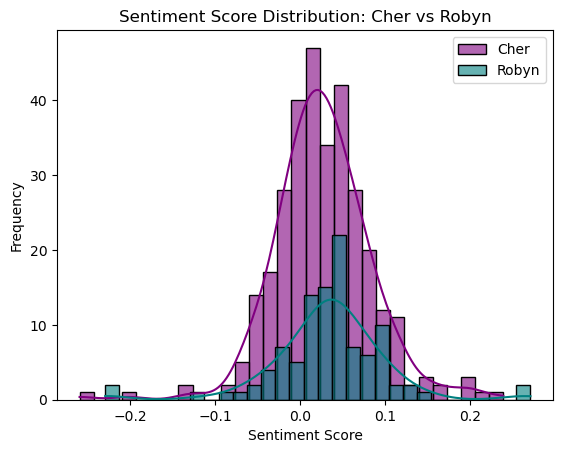

In [14]:
# plot cher
sns.histplot(
    df_lyrics[df_lyrics["artist"] == "cher"]["sentiment_score"],
    bins=30,
    kde=True,
    color="purple",
    label="Cher",
    alpha=0.6,
)
# plot robyn
sns.histplot(
    df_lyrics[df_lyrics["artist"] == "robyn"]["sentiment_score"],
    bins=30,
    kde=True,
    color="teal",
    label="Robyn",
    alpha=0.6,
)

plt.title("Sentiment Score Distribution: Cher vs Robyn")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()

## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/).

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. You do not need to calculate sentiment on non-emoji content for this section.


In [ ]:
# The code for the positive/negative emoji lists was create with the
# assistance of ChatGPT.
positive_keywords = [
    "smile",
    "heart",
    "grin",
    "laugh",
    "sparkle",
    "star",
    "hug",
    "clap",
    "fire",
    "party",
    "rainbow",
    "sun",
    "double exclamation mark",
    "bullseye",
]
negative_keywords = [
    "cry",
    "sad",
    "angry",
    "fear",
    "skull",
    "frown",
    "cold",
    "tired",
    "sick",
    "eyes",
    "cross mark",
    "broken heart",
    "question mark",
    "pile of poo",
]

positive_emojis = [
    e
    for e, meta in emoji.EMOJI_DATA.items()
    if any(k in meta["en"].lower() for k in positive_keywords)
]

negative_emojis = [
    e
    for e, meta in emoji.EMOJI_DATA.items()
    if any(k in meta["en"].lower() for k in negative_keywords)
]


def create_emoji_scoring_dict(
    dictionary_name, list_of_emojis, base_value, verbose=False
):
    score_value = base_value
    for emoji in list_of_emojis:
        emoji_score = score_value
        if emoji in dictionary_name:
            emoji_score = check_sentiment_value(
                emoji, dictionary_name[emoji], score_value, verbose
            )
        dictionary_name[emoji] = emoji_score

    return None


def emoji_sentiment_score(tokens):
    if len(tokens) == 0:
        return None

    sentiment_score = 0
    for word in tokens:
        if len(tokens) == 0:
            print(word, len(tokens))
        if word in emoji_dict:
            sentiment_score += emoji_dict[word]

    return sentiment_score / len(tokens)


# ChatGPT was used to assist in creating this function
def total_emoji_counts(
    dataframe, emojis_list, tokens_col="description", artist_col="artist"
):

    emoji_counts = defaultdict(Counter)

    for _, row in dataframe.iterrows():
        artist = row[artist_col]
        tokens = row[tokens_col]

        for tok in tokens:
            if tok in emojis_list:
                emoji_counts[artist][tok] += 1

    return emoji_counts

In [76]:
# your code here
emoji_dict = {}
conflicting_emojis_list = []

create_emoji_scoring_dict(emoji_dict, positive_emojis, pos_score)
create_emoji_scoring_dict(emoji_dict, negative_emojis, neg_score)

clean_sentiment_dictionary(emoji_dict, conflicting_emojis_list)

emoji_dict

Total words removed from: 5


{'🫀': 1,
 '💓': 1,
 '🖤': 1,
 '💙': 1,
 '💔': 1,
 '🤎': 1,
 '🎯': 1,
 '😼': 1,
 '🎬': 1,
 '👏': 1,
 '👏🏿': 1,
 '👏🏻': 1,
 '👏🏾': 1,
 '👏🏼': 1,
 '👏🏽': 1,
 '💑': 1,
 '💑🏿': 1,
 '💑🏻': 1,
 '👨\u200d❤️\u200d👨': 1,
 '👨\u200d❤\u200d👨': 1,
 '👨🏿\u200d❤️\u200d👨🏿': 1,
 '👨🏿\u200d❤\u200d👨🏿': 1,
 '👨🏿\u200d❤️\u200d👨🏻': 1,
 '👨🏿\u200d❤\u200d👨🏻': 1,
 '👨🏿\u200d❤️\u200d👨🏾': 1,
 '👨🏿\u200d❤\u200d👨🏾': 1,
 '👨🏿\u200d❤️\u200d👨🏼': 1,
 '👨🏿\u200d❤\u200d👨🏼': 1,
 '👨🏿\u200d❤️\u200d👨🏽': 1,
 '👨🏿\u200d❤\u200d👨🏽': 1,
 '👨🏻\u200d❤️\u200d👨🏻': 1,
 '👨🏻\u200d❤\u200d👨🏻': 1,
 '👨🏻\u200d❤️\u200d👨🏿': 1,
 '👨🏻\u200d❤\u200d👨🏿': 1,
 '👨🏻\u200d❤️\u200d👨🏾': 1,
 '👨🏻\u200d❤\u200d👨🏾': 1,
 '👨🏻\u200d❤️\u200d👨🏼': 1,
 '👨🏻\u200d❤\u200d👨🏼': 1,
 '👨🏻\u200d❤️\u200d👨🏽': 1,
 '👨🏻\u200d❤\u200d👨🏽': 1,
 '👨🏾\u200d❤️\u200d👨🏾': 1,
 '👨🏾\u200d❤\u200d👨🏾': 1,
 '👨🏾\u200d❤️\u200d👨🏿': 1,
 '👨🏾\u200d❤\u200d👨🏿': 1,
 '👨🏾\u200d❤️\u200d👨🏻': 1,
 '👨🏾\u200d❤\u200d👨🏻': 1,
 '👨🏾\u200d❤️\u200d👨🏼': 1,
 '👨🏾\u200d❤\u200d👨🏼': 1,
 '👨🏾\u200d❤️\u200d👨🏽': 1,
 '👨🏾\u200d❤\u200d👨🏽': 1,
 '👨🏼\u200d❤️\u200d👨

In [78]:
df_twitter["sentiment_score"] = df_twitter["description"].apply(emoji_sentiment_score)

In [79]:
# Calculate average sentiment score
avgt_cher = df_twitter.loc[df_twitter["artist"] == "cher", "sentiment_score"].mean()
avgt_robyn = df_twitter.loc[df_twitter["artist"] == "robyn", "sentiment_score"].mean()

print(f"Artist: Cher \nAverage sentiment score: {avgt_cher:0.5f}")
print("\n")
print(f"Artist: Robyn \nAverage sentiment score: {avgt_robyn:0.5f}")

Artist: Cher 
Average sentiment score: 0.00694


Artist: Robyn 
Average sentiment score: 0.00570


In [80]:
pos_emoji_counts = total_emoji_counts(df_twitter, positive_emojis)
neg_emoji_counts = total_emoji_counts(df_twitter, negative_emojis)

In [81]:
for artist, counts in pos_emoji_counts.items():
    print(f"\n{artist}:")
    for e, c in counts.most_common(3):
        print(f"  {e}: {c}")


robyn:
  🏳️‍🌈: 1701
  ♥: 1167
  ❤️: 987

cher:
  ❤️: 14715
  🏳️‍🌈: 14122
  ♥: 10154


In [82]:
for artist, counts in neg_emoji_counts.items():
    print(f"\n{artist}:")
    for e, c in counts.most_common(3):
        print(f"  {e}: {c}")


robyn:
  😊: 75
  👀: 57
  😍: 55

cher:
  😊: 1766
  😍: 1541
  😁: 941


Q: What is the average sentiment of your two artists?

A: Cher has an average sentiment score of 0.00694 while Robyn has an average
sentiment score of 0.00570.

---

Q: Which positive emoji is the most popular for each artist? Which negative emoji?

A: The most popular positive emoji for Robyn is 🏳️‍🌈 (rainbow flag) while Cher's is the ❤️ (heart).

For both Cher and Robyn, the top most negative emoji is 😊 (smiling face with smiling eyes).
I do not agree with this answer. The reason for this smiling face emoji is because my
negative and positive emoji lists were not properly cleaned to remove conflicting emojis.
